In [1]:
import pickle
from datasets import load_dataset
import numpy as np


multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20230518")
modified_dataset = multi_lexsum["test"].filter(lambda x: x["summary/short"] != None)

In [2]:
import evaluate

rouge_scoring = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

In [3]:
import os
import json
def load_predicted_data(path):
    predicted = []
    ordered_files = os.listdir(path)
    ordered_files = sorted(ordered_files, key = lambda x: int(x.split(".")[0]))
    for file in ordered_files:
        predicted.append(json.load(open(path+file, "r"))[-1]["content"])

    return predicted

In [4]:
import os
from tqdm import tqdm

## ROUGE
# ['led: rouge1: 48.77', 'led: rouge2: 25.24', 'led: rougeL: 33.67', 'led: rougeLsum: 33.94']
# ['primera: rouge1: 45.74', 'primera: rouge2: 22.83', 'primera: rougeL: 31.92', 'primera: rougeLsum: 32.18']

### BERTScore
# ['led: precision: 0.74', 'led: recall: 0.61', 'led: f1: 0.67']
# ['primera: precision: 0.74', 'primera: recall: 0.62', 'primera: f1: 0.68']

def evaluation(results, model, prompt_type, selection_type):
    predicted = load_predicted_data(f"answers/{model}/{prompt_type}/{selection_type}/")
    bert_scores = bertscore.compute(predictions=predicted, references=modified_dataset["summary/short"][:len(predicted)], model_type="microsoft/deberta-large-mnli", batch_size = 3)
    r_scores = rouge_scoring.compute(predictions=predicted, references=modified_dataset["summary/short"][:len(predicted)], use_stemmer = True)
    
    r_scores = {metric: round(np.mean(val), 3) for metric, val in r_scores.items()}
    bert_scores = {metric: round(np.mean(val[0]), 3) for metric, val in bert_scores.items() if metric != "hashcode"}
    
    results["model"] += [model] * 4
    results["selection_type"] += [selection_type] * 4
    results["prompt_type"] += [prompt_type] * 4
    results["score_value"] += [r_scores["rouge1"], r_scores["rouge2"], r_scores["rougeL"], bert_scores["f1"]]
    results["score_type"] += ["rouge1", "rouge2", "rougeL", "bert_score"]

results = {"model": [], "selection_type": [], "prompt_type": [], "score_value": [], "score_type": []}
for model in tqdm(os.listdir("answers/")):
    for prompt_type in os.listdir(f"answers/{model}/"):
        for selection_type in os.listdir(f"answers/{model}/{prompt_type}/"):
            evaluation(results, model, prompt_type, selection_type)

  0%|          | 0/3 [00:00<?, ?it/s]/home/keddie/anaconda3/envs/facilex_caselaw/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
import pickle
pickle.dump(results, open("results.pickle", "wb"))

In [ ]:
results = pickle.load(open("results.pickle", "rb"))

In [ ]:
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results.shape)
df_results.head()

(280, 5)


,model,selection_type,prompt_type,score_value,score_type
0,mixtral-8x7b-32768,first5last5_bert,cod,0.271,rouge1
1,mixtral-8x7b-32768,first5last5_bert,cod,0.071,rouge2
2,mixtral-8x7b-32768,first5last5_bert,cod,0.164,rougeL
3,mixtral-8x7b-32768,first5last5_bert,cod,0.465,bert_score
4,mixtral-8x7b-32768,random_selection_bert,cod,0.262,rouge1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(<matplotlib.patches.Patch object at 0x7f57e621ef10>, <matplotlib.patches.Patch object at 0x7f57e6c85c10>), (<matplotlib.patches.Patch object at 0x7f57e621c790>, <matplotlib.patches.Patch object at 0x7f57f2dcdf10>), (<matplotlib.patches.Patch object at 0x7f57e621ff90>, <matplotlib.patches.Patch object at 0x7f57f30953d0>), <matplotlib.patches.Patch object at 0x7f57ea724890>, <matplotlib.patches.Patch object at 0x7f57f3095bd0>]
[(<matplotlib.patches.Patch object at 0x7f57e6593310>, <matplotlib.patches.Patch object at 0x7f57f2e6e890>), (<matplotlib.patches.Patch object at 0x7f57f2e60ed0>, <matplotlib.patches.Patch object at 0x7f57f2e6c750>), (<matplotlib.patches.Patch object at 0x7f57e8271890>, <matplotlib.patches.Patch object at 0x7f57f2e6cb10>), <matplotlib.patches.Patch object at 0x7f57f2e6d150>, <matplotlib.patches.Patch object at 0x7f57f2eef350>]
[(<matplotlib.patches.Patch object at 0x7f57e57c3310>, <matplotlib.patches.Patch object at 0x7f57e81f65d0>), (<matplotlib.patches.Patch ob

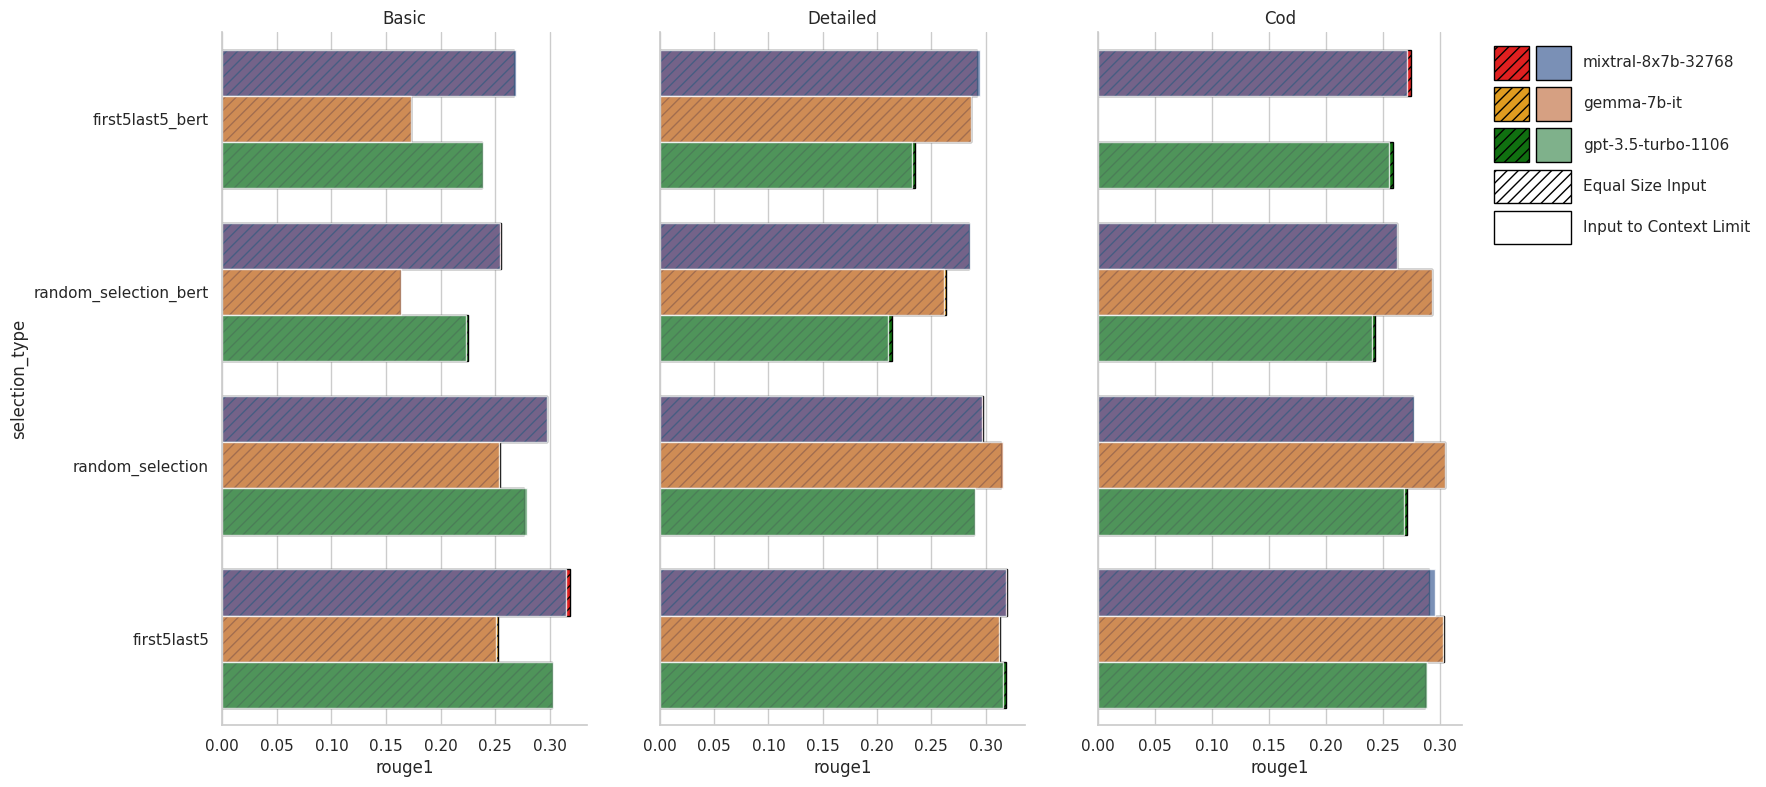

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(<matplotlib.patches.Patch object at 0x7f57e723af90>, <matplotlib.patches.Patch object at 0x7f57e8807e50>), (<matplotlib.patches.Patch object at 0x7f57e7239fd0>, <matplotlib.patches.Patch object at 0x7f57e8807e90>), (<matplotlib.patches.Patch object at 0x7f57e7238750>, <matplotlib.patches.Patch object at 0x7f57e88074d0>), <matplotlib.patches.Patch object at 0x7f57e8805d10>, <matplotlib.patches.Patch object at 0x7f57e88054d0>]
[(<matplotlib.patches.Patch object at 0x7f57e7367510>, <matplotlib.patches.Patch object at 0x7f57e6349e10>), (<matplotlib.patches.Patch object at 0x7f57e73fde50>, <matplotlib.patches.Patch object at 0x7f57e6348510>), (<matplotlib.patches.Patch object at 0x7f57e634ba90>, <matplotlib.patches.Patch object at 0x7f57e634be90>), <matplotlib.patches.Patch object at 0x7f57e634a350>, <matplotlib.patches.Patch object at 0x7f57e634b050>]
[(<matplotlib.patches.Patch object at 0x7f57f2f87a10>, <matplotlib.patches.Patch object at 0x7f57e87b6190>), (<matplotlib.patches.Patch ob

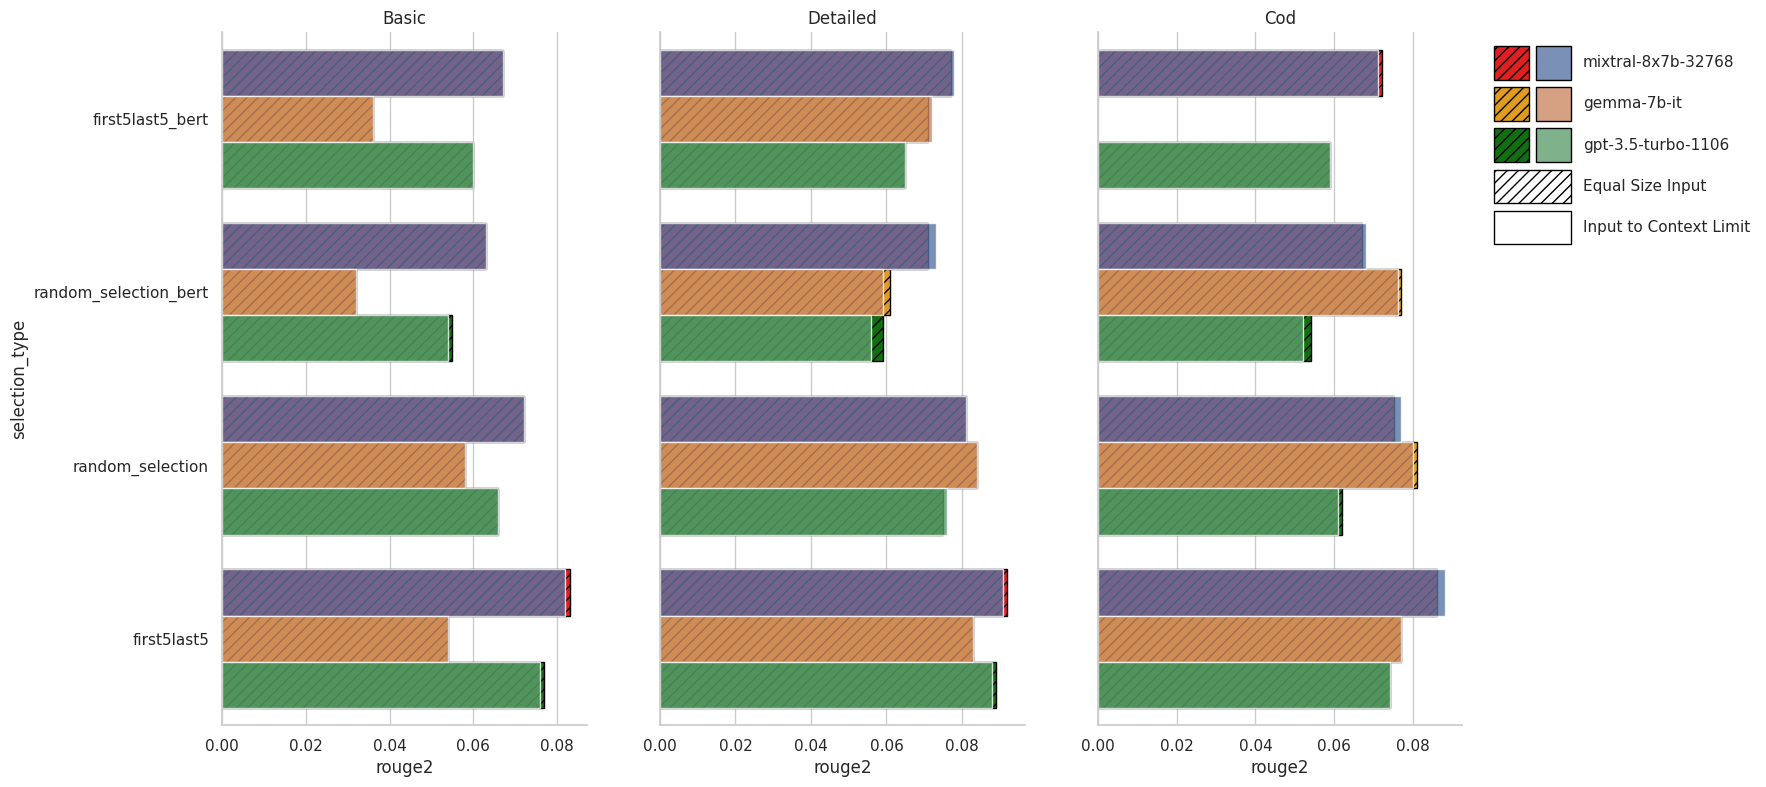

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(<matplotlib.patches.Patch object at 0x7f57e5febfd0>, <matplotlib.patches.Patch object at 0x7f57e6175010>), (<matplotlib.patches.Patch object at 0x7f57e72ba510>, <matplotlib.patches.Patch object at 0x7f57e6174510>), (<matplotlib.patches.Patch object at 0x7f57e6184f50>, <matplotlib.patches.Patch object at 0x7f57e6175550>), <matplotlib.patches.Patch object at 0x7f57e6175990>, <matplotlib.patches.Patch object at 0x7f57e6177c50>]
[(<matplotlib.patches.Patch object at 0x7f57e5f6ca50>, <matplotlib.patches.Patch object at 0x7f57e8ce7e10>), (<matplotlib.patches.Patch object at 0x7f57e5f6d810>, <matplotlib.patches.Patch object at 0x7f57e8ce49d0>), (<matplotlib.patches.Patch object at 0x7f57e8ce6b10>, <matplotlib.patches.Patch object at 0x7f57e8ce41d0>), <matplotlib.patches.Patch object at 0x7f57e8ce5850>, <matplotlib.patches.Patch object at 0x7f57e8ce5990>]
[(<matplotlib.patches.Patch object at 0x7f57e5e947d0>, <matplotlib.patches.Patch object at 0x7f57e5c03f10>), (<matplotlib.patches.Patch ob

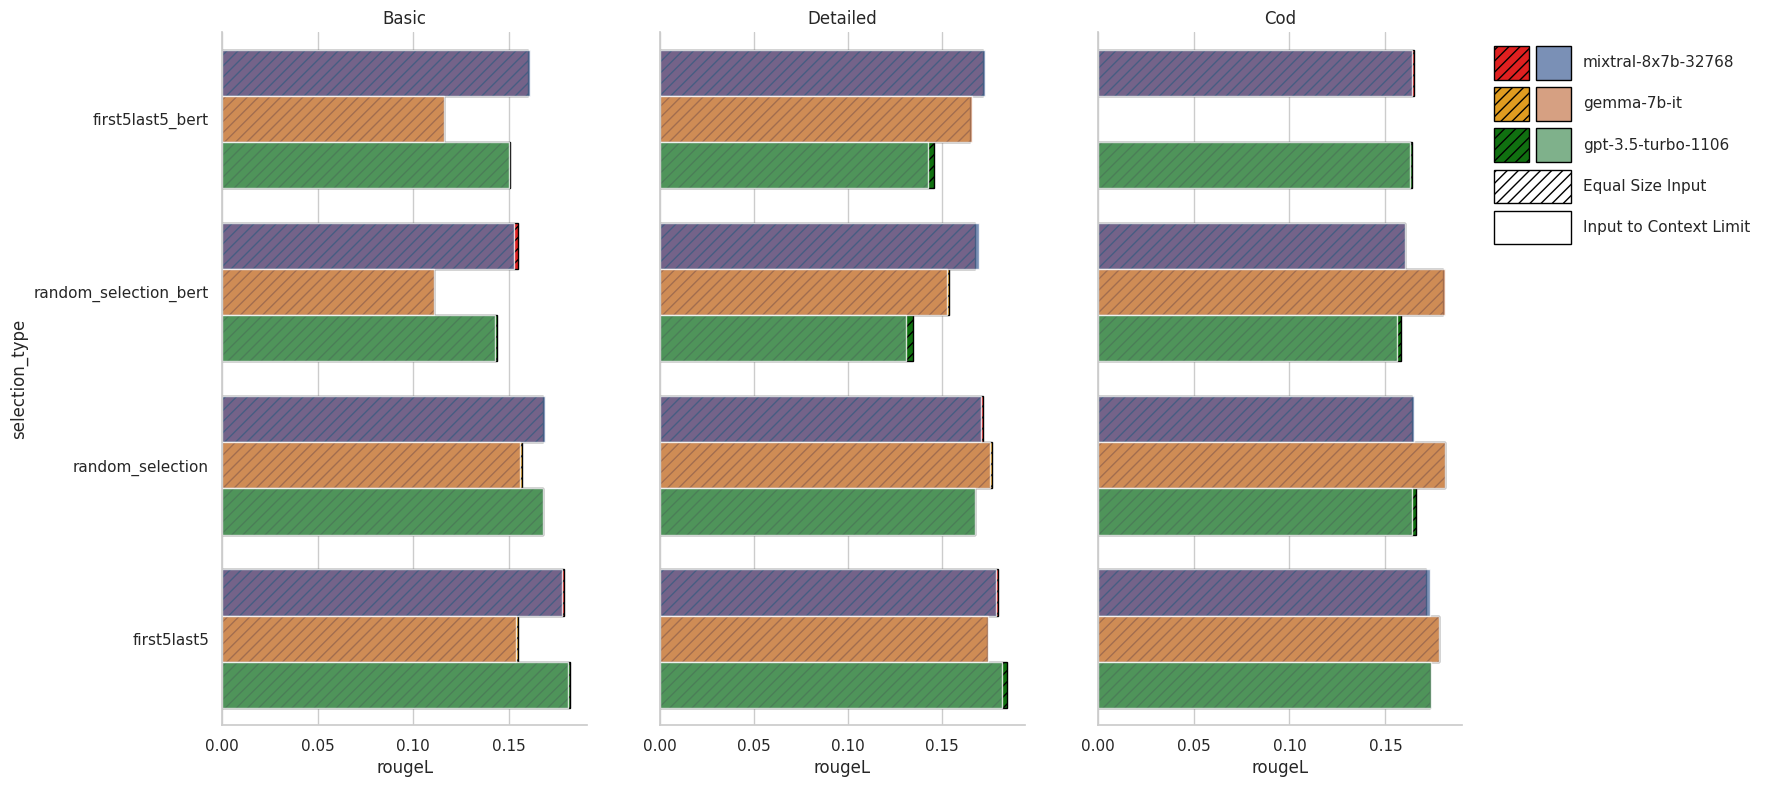

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(<matplotlib.patches.Patch object at 0x7f57e6349f10>, <matplotlib.patches.Patch object at 0x7f57e75bdd90>), (<matplotlib.patches.Patch object at 0x7f57e5d71b50>, <matplotlib.patches.Patch object at 0x7f57e75be850>), (<matplotlib.patches.Patch object at 0x7f57e75bd090>, <matplotlib.patches.Patch object at 0x7f57e75bf290>), <matplotlib.patches.Patch object at 0x7f57e75bfed0>, <matplotlib.patches.Patch object at 0x7f57e75bdcd0>]
[(<matplotlib.patches.Patch object at 0x7f57e830f850>, <matplotlib.patches.Patch object at 0x7f57e830d8d0>), (<matplotlib.patches.Patch object at 0x7f57e830d5d0>, <matplotlib.patches.Patch object at 0x7f57e830f910>), (<matplotlib.patches.Patch object at 0x7f57e830d450>, <matplotlib.patches.Patch object at 0x7f57e830f5d0>), <matplotlib.patches.Patch object at 0x7f57e830e610>, <matplotlib.patches.Patch object at 0x7f57e830db90>]
[(<matplotlib.patches.Patch object at 0x7f57e5b110d0>, <matplotlib.patches.Patch object at 0x7f57e656d190>), (<matplotlib.patches.Patch ob

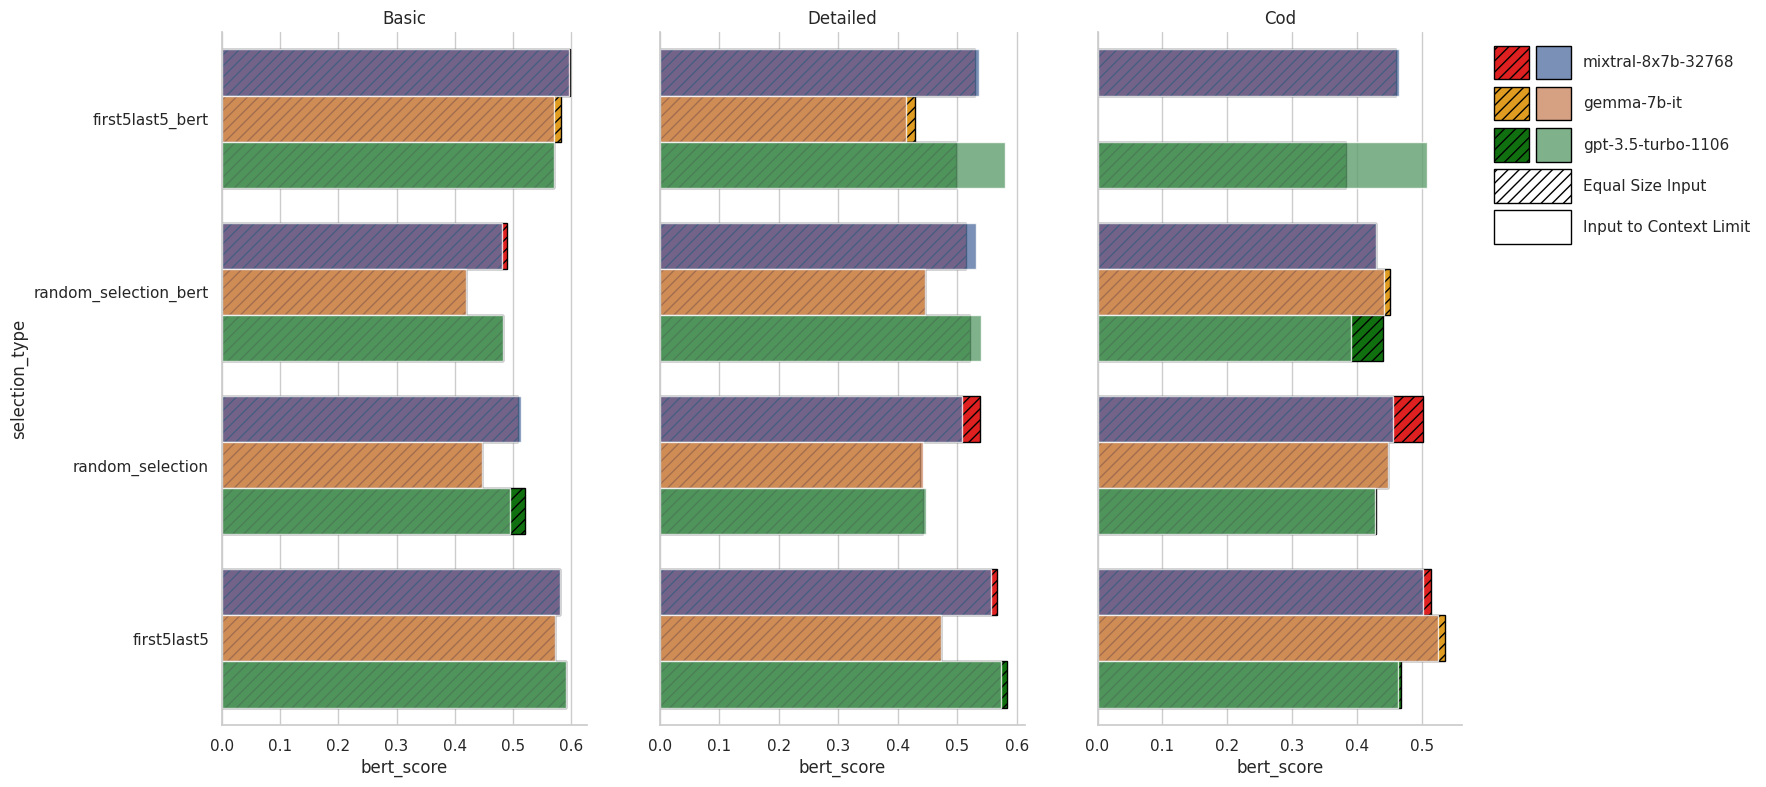

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
import seaborn as sns

def composite_barplot(ax, prompt_type, score_type):
    subset = df_results.copy()
    subset = subset[subset["score_type"] == score_type]
    subset = subset[subset["prompt_type"].str.contains(prompt_type)]
    subset_eq = subset[subset["prompt_type"].str.contains("equal")]
    subset_normal = subset[~subset["prompt_type"].str.contains("equal")]

    sns.set_theme(style="whitegrid")
    # sns.catplot(kind = "bar", data = subset, x = "selection_type", y = "score_value", hue = "model", col = "score_type", row="prompt_type")
    plot_eq = sns.barplot(ax=ax, data=subset_eq, y="selection_type", x="score_value", hue="model", alpha=1, palette=sns.color_palette(["red", "orange", "green"]), hatch="///", orient="h", edgecolor="black")
    plot_normal = sns.barplot(ax=ax, data=subset_normal, y="selection_type", x="score_value", hue="model", alpha=0.8, orient="h")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), frameon=False)
    children = [c for c in plot_normal.axes.get_children() if type(c) == Rectangle and (c.get_label() != "_nolegend_" and c.get_label() != "")]
    colors = [(c.get_facecolor(), c.get_hatch()) for c in children]
    handles = [Patch(facecolor=color, hatch=hatch, edgecolor="black") for color, hatch in colors]
    labels = [c.get_label() for c in children]
    handles = [(handles[idx], handles[idx+3]) for idx in range(0,len(handles)-3,1)]
    handles += [Patch(facecolor="white", hatch="///", edgecolor="black")]
    handles += [Patch(facecolor="white", hatch="", edgecolor="black")]
    labels = [labels[idx] for idx in range(0,len(labels)-3,1)]
    labels += ["Equal Size Input"]
    labels += ["Input to Context Limit"]
    print(handles)
    plot_normal.legend().remove()
    plot_eq.legend().remove()
    plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(1.05,1), frameon=False, handler_map={tuple: HandlerTuple(ndivide=None)}, handleheight=3, handlelength=5)
    sns.despine()
    plot_eq.set_title(prompt_type.title())
    plot_eq.set_xlabel(score_type)
    

sns.set_theme(style = "whitegrid")
for score in df_results["score_type"].unique():
    fig, axes = plt.subplots(1, 3, figsize=(16,9), sharey=True)
    composite_barplot(axes[0], "basic", score)
    composite_barplot(axes[1], "detailed", score)
    composite_barplot(axes[2], "cod", score)
    fig.savefig(f"{score}.png", transparent=True)
    # plt.show()
